In [1]:

import unittest
import numpy as np
import treecorr
import healpy as hp
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import os
import coord
from numba import jit, njit
import cupy as cp
import itertools
from functools import partial
from UFalcon.utils import kappa_to_gamma
sys.path.insert(1,'../src/')

from CosmoFuse.correlations_GPU import Correlation_GPU
from CosmoFuse.utils import pixel2RaDec
from cupyx.profiler import benchmark
#%set_env CUPY_ACCELERATORS=cub,cutensor
#%env


In [ ]:
nside = 512
radius_patch = 90/60
radius_filter = 5 * radius_patch
theta_Q = np.radians(radius_filter)
nbins = 15
des_map = hp.ud_grade(hp.read_map("~/research/lfi/local/DESY3_Mask.fits"), nside)


map_inds = np.where(des_map!=0)[0]
phi_center = np.loadtxt(f"/e/ocean1/users/dgebauer/sbi/CosmoFuse/Q{int(radius_patch*60)}/patch_center_original_phi.dat")[::2]
theta_center = np.loadtxt(f"/e/ocean1/users/dgebauer/sbi/CosmoFuse/Q{int(radius_patch*60)}/patch_center_original_theta.dat")[::2]

n_patches = len(phi_center)

npix = hp.nside2npix(nside)



#shear_maps = np.zeros((2,2,hp.nside2npix(nside)))
#shear_maps[:,:,map_inds] = np.load("./data/shear_maps.npy")        
kappa_maps = np.zeros((4,hp.nside2npix(nside)))
shear_maps = np.zeros((4,2,hp.nside2npix(nside)))
kappa_maps = hp.ud_grade(np.load("/data/taurus/users/dgebauer/CCNN_maps/cosmo_fiducial/kappa/nzmap_0000.npy"), nside)
for i in range(4):
    shear_maps[i,...] = kappa_to_gamma(kappa_maps[i,:])

min_theta = 20
max_theta = 250

binedges = np.geomspace(min_theta, max_theta, nbins+1)
binedges = binedges[np.where(binedges<2*radius_patch*60-10)[0]]
nbins = len(binedges)-1

min_theta = binedges[0]
max_theta = binedges[-1]

w = np.ones_like(shear_maps[0,0])


/home/moon/dgebauer/anaconda3/envs/lfi_gpu/lib/python3.10/site-packages/UFalcon/utils.py:198: RuntimeWarning: divide by zero encountered in divide
  -np.sqrt(((ell + 2.0) * (ell - 1)) / ((ell + 1) * ell)),
/home/moon/dgebauer/anaconda3/envs/lfi_gpu/lib/python3.10/site-packages/UFalcon/utils.py:198: RuntimeWarning: invalid value encountered in sqrt
  -np.sqrt(((ell + 2.0) * (ell - 1)) / ((ell + 1) * ell)),


In [3]:
corr = Correlation_GPU(nside, phi_center, theta_center, nbins=nbins, patch_size=radius_patch*60, theta_min=min_theta, theta_max=max_theta, mask=des_map, fastmath=False)

recalc=True
if recalc:
    corr.preprocess(threads=100)

Calculating pairs for Aperture Mass...
Calculating pairs for 2PCF...


In [11]:
%time corr.prepare_gpu()
%time corr.load_maps(shear_maps[3,0], shear_maps[3,1], shear_maps[3,0], shear_maps[3,1], w, w, flip_g1=True)

CPU times: user 879 ms, sys: 1.98 s, total: 2.85 s
Wall time: 2.85 s
CPU times: user 39 ms, sys: 3.98 ms, total: 43 ms
Wall time: 42.6 ms


In [26]:
%time xip_gpu, xim_gpu = corr.get_all_xipm()

xip_gpu = xip_gpu.get()
xim_gpu = xim_gpu.get()

CPU times: user 6.19 ms, sys: 3.99 ms, total: 10.2 ms
Wall time: 8.75 ms


In [14]:
benchmark(corr.get_all_xipm, (), n_repeat=100, n_warmup=20, )

get_all_xipm        :    CPU:  2391.084 us   +/- 132.715 (min:  2307.002 / max:  3562.994) us     GPU-0: 62501.038 us   +/- 21.547 (min: 62444.546 / max: 62585.857) us

In [23]:
%%time
xip_treecorr = np.zeros((n_patches,nbins))
xim_treecorr = np.zeros((n_patches,nbins))


correlation = treecorr.GGCorrelation(nbins=nbins, min_sep=min_theta, max_sep=max_theta, sep_units='arcmin', brute=True, metric='Arc', bin_slop=0.)
for i in range(n_patches):
    vec = hp.ang2vec(theta_center[i], phi_center[i])
    patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
    pix_inds = np.intersect1d(patch_inds, map_inds)
    g11 = shear_maps[3,0,pix_inds]
    g21 = shear_maps[3,1,pix_inds]
    g12 = shear_maps[3,0,pix_inds]
    g22 = shear_maps[3,1,pix_inds]
    ra, dec = pixel2RaDec(pix_inds, nside)
    catalog1 = treecorr.Catalog(ra=ra, dec=dec, g1=g11, g2=g21, w=w[pix_inds], ra_units='rad', dec_units='rad', flip_g1=True)
    catalog2 = treecorr.Catalog(ra=ra, dec=dec, g1=g12, g2=g22, w=w[pix_inds], ra_units='rad', dec_units='rad', flip_g1=True)
    correlation.process(catalog1, catalog2)
    xip_treecorr[i,:] = correlation.xip
    xim_treecorr[i,:] = correlation.xim
    
rnom = correlation.rnom

CPU times: user 25min 19s, sys: 419 ms, total: 25min 19s
Wall time: 9.56 s


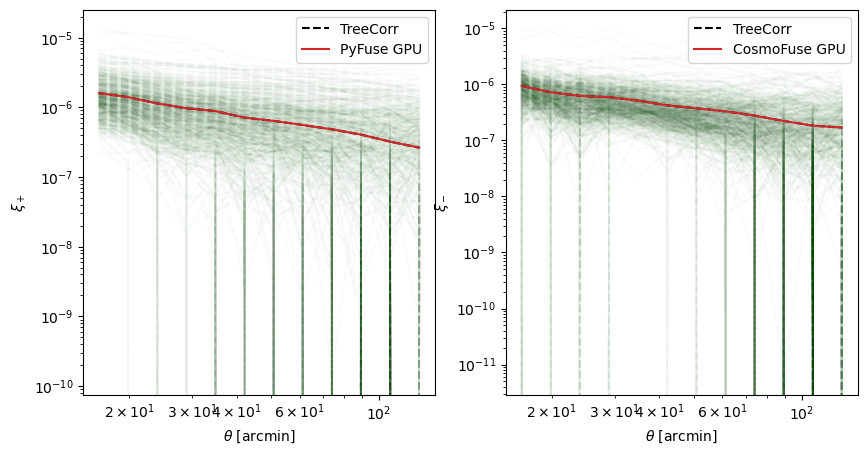

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(n_patches):
    ax[0].plot(rnom, xip_treecorr[i], c='k', ls='--', alpha=.01)
    ax[0].plot(rnom, xip_gpu[i], c='C2', alpha=.01)
ax[0].plot(rnom, xip_treecorr.mean(axis=0), c='k', ls='--', label="TreeCorr")
ax[0].plot(rnom, xip_gpu.mean(axis=0), c='C3', label="PyFuse GPU")
ax[0].set_ylabel(r"$\xi_+$")
ax[0].set_xlabel(r"$\theta$ [arcmin]")
ax[0].legend()

for i in range(n_patches):
    ax[1].plot(rnom, xim_treecorr[i], c='k', ls='--', alpha=.01)
    ax[1].plot(rnom, xim_gpu[i], c='C2', alpha=.01)
ax[1].plot(rnom, xim_treecorr.mean(axis=0), c='k', ls='--', label="TreeCorr")
ax[1].plot(rnom, xim_gpu.mean(axis=0), c='C3', label="CosmoFuse GPU")
ax[1].set_ylabel(r"$\xi_-$")
ax[1].set_xlabel(r"$\theta$ [arcmin]")
ax[1].legend()

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')


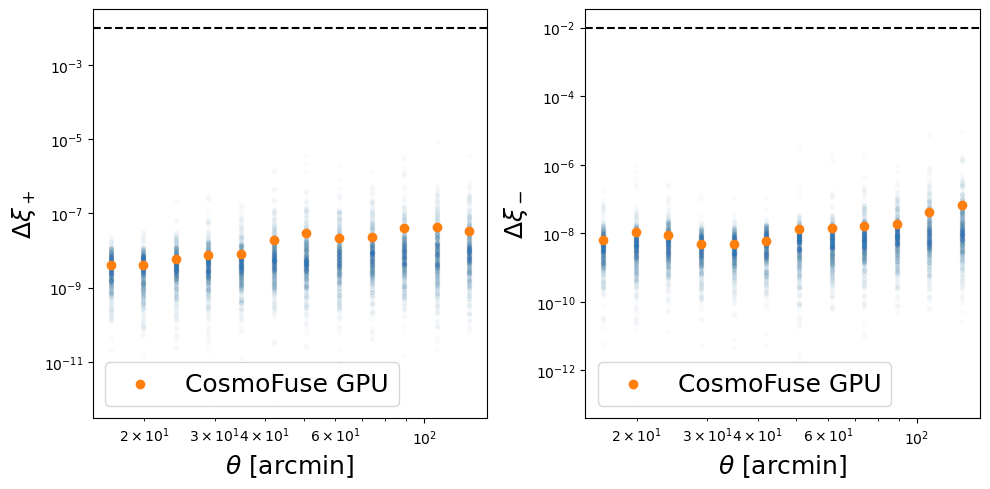

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(n_patches):
    ax[0].scatter(rnom, np.abs(1-(xip_gpu/xip_treecorr))[i], c='C0', alpha=.015, s=8)
ax[0].scatter(rnom, np.abs(1-(xip_gpu/xip_treecorr)).mean(axis=0), c='C1', label="CosmoFuse GPU")
ax[0].axhline(0.01, ls='--', c='k')
ax[0].set_ylabel(r"$\Delta \xi_+$", fontsize=18)
ax[0].set_xlabel(r"$\theta$ [arcmin]", fontsize=18)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

for i in range(n_patches):
    ax[1].scatter(rnom, np.abs(1-(xim_gpu/xim_treecorr))[i], c='C0', alpha=.015, s=8)
ax[1].scatter(rnom, np.abs(1-(xim_gpu/xim_treecorr)).mean(axis=0), c='C1', label="CosmoFuse GPU")
ax[1].axhline(0.01, ls='--', c='k')
ax[1].set_ylabel(r"$\Delta \xi_-$", fontsize=18)
ax[1].set_xlabel(r"$\theta$ [arcmin]", fontsize=18)
ax[1].set_xscale('log')
ax[1].set_yscale('log')


ax[0].legend(fontsize=18, loc='lower left')
ax[1].legend(fontsize=18, loc='lower left')
fig.tight_layout()


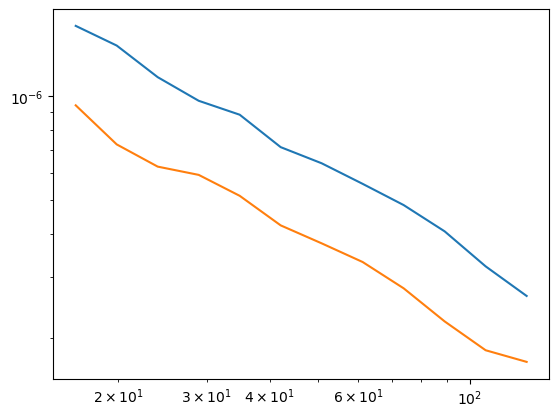

In [10]:
xip_gpu.shape

plt.loglog(rnom, xip_gpu.mean(axis=0))
plt.loglog(rnom, xim_gpu.mean(axis=0))